# LongCandleStrategy models
Model selection for predict long candle


To install dependencies to this notebook uncomment the code below

In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
#%pip install binance-connector==1.13.0
%pip install pandas
%pip install scikit-learn
%pip install tensorflow==2.11.0
%pip install keras==2.11.0
%pip install scikeras
%pip install keras-tuner

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Feature engineering
Read features and targets from bot's hjistory

In [8]:
import os

# Downloading latest pytrade2 data
os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
data_dir=f"../data/yandex-cloud"
  
print(f"Download completed. Local data dir: {data_dir}")

deploy_lib.sh: line 4: yc: command not found
INFO: Retrieving list of remote files for s3://pytrade2/data/ ...


Sync pytrade2 data from s3://pytrade2/data to /home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yandex-cloud


INFO: No cache file found, creating it.
INFO: Compiling list of local files...
INFO: Running stat() and reading/calculating MD5 values on 1805 files, this may take some time...
INFO: [1000/1805]
INFO: Found 142 remote files, 1805 local files
INFO: Verifying attributes...
INFO: disabled md5 check for LongCandleDenseStrategy/Xy/2023-10-07_BTC-USDT_x.csv
INFO: disabled md5 check for LongCandleDenseStrategy/Xy/2023-10-08_BTC-USDT_x.csv
INFO: disabled md5 check for LongCandleDenseStrategy/Xy/2023-10-09_BTC-USDT_x.csv
INFO: Summary: 16 remote files to download, 1674 local files to delete, 0 local files to hardlink


download: 's3://pytrade2/data/LongCandleDenseStrategy/Xy/2023-11-03_BTC-USDT_learn_x.csv' -> '/home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-11-03_BTC-USDT_learn_x.csv'  [1 of 16]
 2331 of 2331   100% in    0s    19.01 kB/s  done
download: 's3://pytrade2/data/LongCandleDenseStrategy/Xy/2023-11-03_BTC-USDT_learn_y.csv' -> '/home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-11-03_BTC-USDT_learn_y.csv'  [2 of 16]
 70 of 70   100% in    0s  1014.96 B/s  done
download: 's3://pytrade2/data/LongCandleDenseStrategy/Xy/2023-11-03_BTC-USDT_x.csv' -> '/home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-11-03_BTC-USDT_x.csv'  [3 of 16]
 1554 of 1554   100% in    0s    20.71 kB/s  done
download: 's3://pytrade2/data/LongCandleDenseStrategy/Xy/2023-11-03_BTC-USDT_y.csv' -> '/home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yande

### Read data from bot's history

In [27]:
import os
import glob
import pandas as pd
from datetime import timedelta,date
ticker="BTC-USDT"

def read_last_data(strategy, days=1, n=None):
    """ Read last last day from bot history """
    
    def read_last(symbol: str, name: str, days=1):
        data_dir=f"./../data/yandex-cloud/{strategy}/Xy"
        file_paths = sorted([f"{data_dir}/{f}" for f in os.listdir(data_dir) if f.endswith(f"{symbol}_{name}.csv")])[-days:]
        print(file_paths)
        return pd.concat([pd.read_csv(f, parse_dates=True, index_col='close_time') for f in file_paths])

    x=read_last(ticker, "learn_x", days)
    y=read_last(ticker, "learn_y", days)
    if n: 
        x=x.tail(n)
        y=y.tail(n)
    return x.fillna(method='bfill'),y.fillna(method='bfill').dropna()

strategy="LongCandleDenseStrategy"
#strategy="LSTMBidAskRegressionStrategy"
x,y = read_last_data(strategy, days=3, n=None)
print(f"Raw x len: {len(x)}, raw y len: {len(y)}")


['./../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-11-02_BTC-USDT_learn_x.csv', './../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-11-03_BTC-USDT_learn_x.csv', './../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-11-04_BTC-USDT_learn_x.csv']
['./../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-11-02_BTC-USDT_learn_y.csv', './../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-11-03_BTC-USDT_learn_y.csv', './../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-11-04_BTC-USDT_learn_y.csv']
Raw x len: 790, raw y len: 790


In [31]:
y.tail()

,signal
close_time,
2023-11-04 06:53:06.114,0
2023-11-04 06:53:09.513,0
2023-11-04 06:54:09.513,0
2023-11-04 06:54:13.128,1
2023-11-04 06:55:13.128,0


X len: 54347, y len: 54347


### Train test split

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler,OneHotEncoder
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import *
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner

def train_test_split(x,y):
    test_size=0.3
    test_index = int(len(x)*(1-test_size))
    x_train, y_train, x_test, y_test = x.iloc[:test_index], y.iloc[:test_index], x.iloc[test_index:], y.iloc[test_index:]
    time_cols=[col for col in x.columns if col.startswith("time")]
    float_cols = list(set(x.columns)-set(time_cols))

    x_pipe = Pipeline(
        [("xscaler", ColumnTransformer([("xrs", RobustScaler(), float_cols)], remainder="passthrough")),
         ("xmms", MinMaxScaler())])
    
    x_pipe.fit(x_train)

    y_pipe = Pipeline([('adjust_labels', OneHotEncoder(categories=[[-1, 0, 1]], sparse=False, drop=None))])
    y_pipe.fit(y_train)
    
    #x_scaler, y_scaler = MinMaxScaler().fit(X_train), MinMaxScaler().fit(y_train)
    x_train, y_train = x_pipe.transform(x_train), y_pipe.transform(y_train)
    x_test, y_test = x_pipe.transform(x_test), y_pipe.transform(y_test)
    print(f"Train size: {x_train.shape[0]}, test size: {x_test.shape[0]}")
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = train_test_split(x, y)

print(f"X shape: {x_train.shape}, y shape: {y_train.shape}")
print(f"X shape: {x_test.shape}, y shape: {y_test.shape}")

Train size: 553, test size: 237
X shape: (553, 63), y shape: (553, 3)
X shape: (237, 63), y shape: (237, 3)


## Model tuning


In [5]:
%%capture
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import *
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner

In [57]:
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import *
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner

x_size = x_train.shape[1]
y_size = y_train.shape[1]


def create_tuner_model(hp):
    """ Create model for hyperparameter tuning """

    #hp_lstm2_units=hp.Int("lstm2_units", min_value=160, max_value=500)
    hp_dense1_units=hp.Int("dense1_units", min_value=80, max_value=500)
    hp_dense2_units=hp.Int("dense2_units", min_value=80, max_value=1000)
    hp_dense3_units=hp.Int("dense3_units", min_value=80, max_value=1000)
    hp_dense4_units=hp.Int("dense4_units", min_value=80, max_value=100)
    
    
    model = Sequential()
    model.add(Input(shape=(x_size,)))
    model.add(Dense(hp_dense1_units, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(hp_dense2_units, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(hp_dense3_units, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(hp_dense4_units, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(y_size, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    #model.build()
    #model.fit(x_train[:10], y_train[:10], epochs=1)
    
    # Load weights
    #self.load_last_model(model)
    model.summary()
    return model
    
window_size = 10

def create_tuner(max_trials):
    # Tune the model
    # tuner=keras_tuner.Hyperband(
    #     hypermodel=create_tuner_model,
    #     objective="val_mse",
    #     max_epochs=5,
    #     factor=3,
    #     hyperband_iterations=1,
    #     seed=None,
    #     hyperparameters=None,
    #     tune_new_entries=True,
    #     allow_new_entries=True,
    #     max_retries_per_trial=0,
    #     max_consecutive_failed_trials=3
    # )
    tuner=keras_tuner.BayesianOptimization(
        hypermodel=create_tuner_model,
        objective="categorical_accuracy",
        max_trials=max_trials,
        num_initial_points=None,
        alpha=0.0001,
        beta=2.6,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
        overwrite=True,
        directory=f"./tmp/{strategy}/tune",
        project_name="pytrade2",    
    )
    # tuner = keras_tuner.RandomSearch(
    #     hypermodel=create_tuner_model,
    #     objective="val_mse",
    #     max_trials=3,
    #     executions_per_trial=2,
    #     overwrite=True,
    #     directory=f"./tmp/{strategy}/tune",
    #     project_name="pytrade2",
    #     )
    tuner.search_space_summary()
    return tuner

# def tuner_search(max_trials,train_gen, test_gen):
#     tuner = create_tuner(max_trials)
#     tuner.search(train_gen,epochs=2, validation_data=test_gen)
#     return tuner

# train_gen = TimeseriesGenerator(x_train, y_train, length=window_size)
# test_gen = TimeseriesGenerator(x_test, y_test, length=window_size)

# Uncomment to do optimize
tuner=create_tuner(3)
tuner = tuner.search(x_train, y_train, validation_data=(x_test, y_test))
#tuner = tuner_search(10, x_train, test_gen)





Trial 3 Complete [00h 00m 01s]
categorical_accuracy: 0.7396021485328674

Best categorical_accuracy So Far: 0.7631102800369263
Total elapsed time: 00h 00m 04s
INFO:tensorflow:Oracle triggered exit


Epoch 1/5
5/5 [==============================] - 2s 230ms/step - loss: 0.2165 - mse: 0.0734 - val_loss: 0.0701 - val_mse: 0.0076
Epoch 2/5
5/5 [==============================] - 1s 155ms/step - loss: 0.1696 - mse: 0.0465 - val_loss: 0.0659 - val_mse: 0.0069
Epoch 3/5
5/5 [==============================] - 1s 157ms/step - loss: 0.1959 - mse: 0.0566 - val_loss: 0.0527 - val_mse: 0.0040
Epoch 4/5
5/5 [==============================] - 1s 157ms/step - loss: 0.1645 - mse: 0.0414 - val_loss: 0.0721 - val_mse: 0.0072
Epoch 5/5
5/5 [==============================] - 1s 158ms/step - loss: 0.1932 - mse: 0.0478 - val_loss: 0.0521 - val_mse: 0.0042
Epoch 1/5
5/5 [==============================] - 2s 222ms/step - loss: 0.3494 - mse: 0.1873 - val_loss: 0.3489 - val_mse: 0.2046
Epoch 2/5
5/5 [==============================] - 1s 151ms/step - loss: 0.3753 - mse: 0.2211 - val_loss: 0.0606 - val_mse: 0.0057
Epoch 3/5
5/5 [==============================] - 1s 151ms/step - loss: 0.1562 - mse: 0.0331 - val

{'Model(sequential)': <keras.callbacks.History at 0x7fc6afdddd30>}

## Model evaluation

Creating model([128, 512, 64]), input shape=(63,)
Epoch 1/20
5/5 [==============================] - 1s 35ms/step - loss: 0.8630 - categorical_accuracy: 0.6763 - val_loss: 0.7685 - val_categorical_accuracy: 0.7553
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.7537 - categorical_accuracy: 0.7631 - val_loss: 0.7599 - val_categorical_accuracy: 0.7553
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.7152 - categorical_accuracy: 0.7631 - val_loss: 0.7743 - val_categorical_accuracy: 0.7553
Epoch 4/20
5/5 [==============================] - 0s 9ms/step - loss: 0.7206 - categorical_accuracy: 0.7631 - val_loss: 0.7579 - val_categorical_accuracy: 0.7553
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.7058 - categorical_accuracy: 0.7631 - val_loss: 0.7383 - val_categorical_accuracy: 0.7553
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.6923 - categorical_accuracy: 0.7631 - val_loss: 0.7295 - val_categ

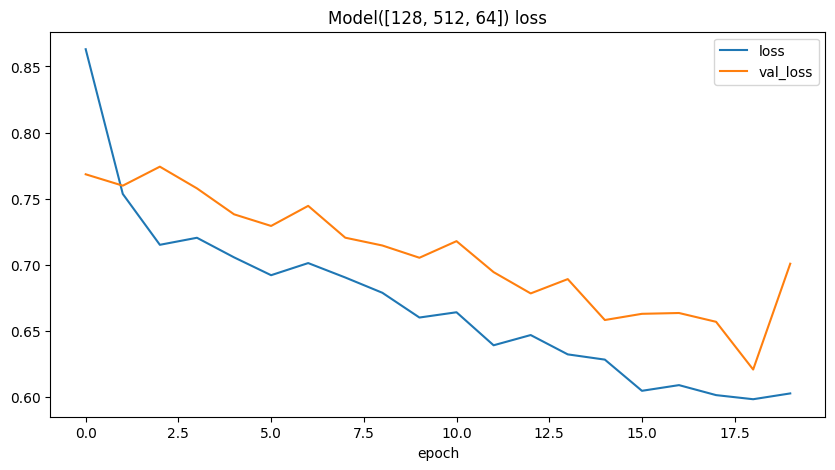

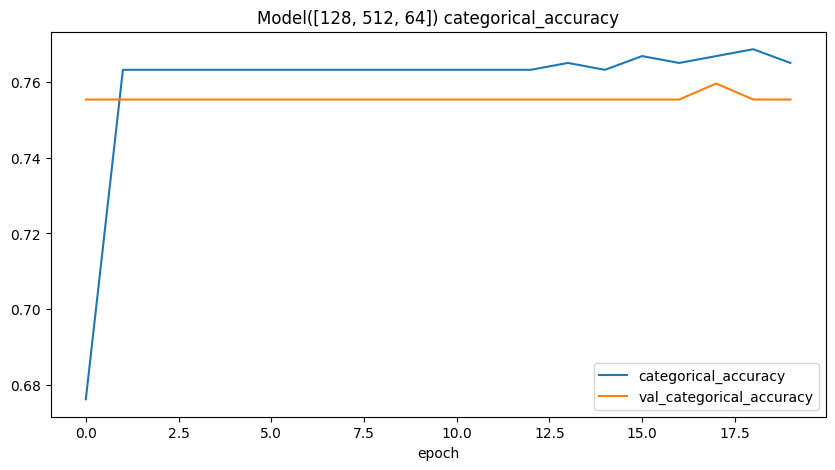

In [59]:
import plotly.express as px
import collections

# def create_model_prod(X_train, y_train, window_size):
#     model = Sequential()
#     model.add(LSTM(128,  return_sequences=True, input_shape=(window_size, X_train.shape[1])))
#     model.add(Dropout(0.2))
#     model.add(LSTM(32))         
#     model.add(Dropout(0.2))
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(y_train.shape[1], activation='linear'))
#     #model.add(Dense(y_train.shape[1], activation='softmax'))
#     model.compile(optimizer='adam', loss='mae', metrics=['mse'])
#     return model  
plot_figsize=(10,5)
#def create_model(X_train, y_train, window_size, lstm1_units, lstm2_units, dense1_units, dense2_units):
def create_models(*specs):
    results={}
    for unit_spec in specs:
        window_size=unit_spec[0]
        yield create_model(X_train, y_train, window_size, unit_spec[1:])

def create_model(x_train,  y_train, specs):
    """ Create model with layers given in specs """

    input_shape=(x_train.shape[1],)
    print(f"Creating model({specs}), input shape={input_shape}")

    model = Sequential()
    model.add(Input(shape=input_shape))

    # Keras layers
    for units in specs:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(y_train.shape[1], activation='softmax')) # Softmax for classification
        
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

def plot_history_plotly(df, title):
    px.line(df,title=title).update_traces(mode='lines+markers').show()
    
def plot_history_plt(df, title):
#         for name in names:
#             plt.plot(history.history[name])
        plt.plot(df)
        #Captions and show the plot
        plt.title(title)
        #plt.ylabel(metric_name)
        plt.xlabel('epoch')
        plt.legend(df.columns)
        #plt.legend(names, loc='upper left')
        plt.show()    

def plot_history(model_name, history, plot_func, metric=None):
    """ Plot history loss and metrics"""
    metric_names = [metric] if metric else history.history
    # Print all merrics
    for metric_name in metric_names:
        # Validation metrics names will be calculated from related train metrics
        if metric_name.startswith("val_"): continue

        # Plot metric and related test (val_..) metric
        plt.figure(figsize=plot_figsize)
        title=f"{model_name} {metric_name}"
        names=[metric_name, f"val_{metric_name}"]
        
        df=pd.DataFrame()
        for name in names:
            df[name] = history.history[name]
        plot_func(df, title)
        #px.line(df,title=title).update_traces(mode='lines+markers').show()

        
#         for name in names:
#             plt.plot(history.history[name])
        # Captions and show the plot
#         plt.title(f"{model_name} {metric_name}")
#         plt.ylabel(metric_name)
#         plt.xlabel('epoch')
#         plt.legend(names, loc='upper left')
#         plt.show()

def fit_model(model, train_gen, test_gen, epochs):
    # Fit the model
    steps_per_epoch=5
    history=model.fit(train_gen, validation_data=test_gen, epochs=epochs, steps_per_epoch=steps_per_epoch)
    return history



def evaluate_models(epochs=10, *specs):
    results={}
    for unit_spec in specs:
        #print(unit_spec)
        model = create_model(x_train, y_train,unit_spec)
        
        steps_per_epoch=5
        history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, steps_per_epoch=steps_per_epoch)
        model_name = f"Model({unit_spec})"
        results[model_name] = history
    return results

def plot_res(results, plot_func):
    for model_name in results:
        plot_history(model_name, results[model_name], plot_func, None)


        
# Good: Current LSTM2: 10, 320, 0.2, 160, 0.2, 40, 0.2, 16, 0.1


eval_res = evaluate_models(20, 
                                  [128, 512, 64]
                                )

plot_res(eval_res, plot_history_plt)


In [61]:
def plot_history_plt2(df, title):
#         for name in names:
#             plt.plot(history.history[name])
        plt.plot(df[2:])
        #Captions and show the plot
        plt.title(title)
        #plt.ylabel(metric_name)
        plt.xlabel('epoch')
        plt.legend(df.columns)
        #plt.legend(names, loc='upper left')
        plt.show() 
plot_res(eval_res, plot_history_plotly)

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>